In [32]:
from __future__ import division
from astropy.io import fits
import os,glob,sys
import glob
import copy
import numpy as np
from astropy.table import Table, Column
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
import astroscrappy
from astropy.convolution import Gaussian1DKernel, convolve
from scipy import special as sp

In [3]:
# define path
path = '/Users/runquanguan/Documents/136P3/Mix'

In [4]:
os.chdir(path)
filename = glob.glob('*')

## Reduce Function

In [5]:
def get_bias(folder):
    Bias = []
    ARRAY = []
    # pick out bias frame
    for file in folder:
        hdul = fits.open(file)
        TYPE = hdul[0].header['OBJECT']
        if TYPE == 'bias':
            Bias.append(file)
        else:
            pass
            
    # extract data array from data 
    for file in Bias:
        hdul_b = fits.open(file)
        array = hdul_b[0].data
        # form arrays as a list
        ARRAY.append(array[80:2650,100:400])
    # turn list into array again to sum up
    ARRAY = np.array(ARRAY)
    # sum up
    SUM = ARRAY.sum(axis=0)
    # average out
    AVG = SUM/len(ARRAY)
    # return result
    return AVG


def Flat(folder):
    
    L = []
    ARRAY = []
    bias_frame = get_bias(folder)

    for file in folder:
        hdul = fits.open(file)
        header = hdul[0].header
        FRAME = hdul[0].header['OBJECT']  
        if FRAME=='dome_flat':
            L.append(file)
    # Flat = (file-dark-bias)/EXPT
    for file in L:
        hdul = fits.open(file)
        array = hdul[0].data
        ARRAY.append(array[80:2650,100:400])
        
    ARRAY = np.array(ARRAY)
    SUM = ARRAY.sum(axis=0)
    AVG = SUM/len(ARRAY)
    FLAT = AVG - bias_frame
    FLAT = FLAT/np.mean(FLAT)
    return FLAT

In [6]:
def reduce_frame(folder):
    
    L = []
    Reduced = []
    
    # define bias frame
    bias_frame = get_bias(filename)
    Flat_frame = Flat(filename)
    
    # find B science frame
    for file in folder:
        hdul = fits.open(file)
        header = hdul[0].header
        FRAME = hdul[0].header['OBJECT']  
        EXPT = hdul[0].header['EXPTIME']
        if FRAME=='arc':
            L.append(file)
        else:
            pass
             
    for file in L:
        hdul = fits.open(file)
        image_data = hdul[0].data[80:2650,100:400]
        image_header = hdul[0].header
        
        DATA = (image_data - bias_frame) / Flat_frame
        new_file = file[0:5]+"_RDUU"+file[5:9]
        outhdu = fits.PrimaryHDU(data = DATA, header = image_header)
        outhdu.writeto(new_file,overwrite=True)
        
        Reduced.append(new_file)
    return Reduced

In [7]:
stacked_data = fits.getdata('stacked.fits')

In [8]:
spectrum2D = stacked_data
spectrum1D = np.mean(spectrum2D,axis=1)

spectrum1D_list = list(spectrum1D)
list1 = list(spectrum1D)
list1.sort() 

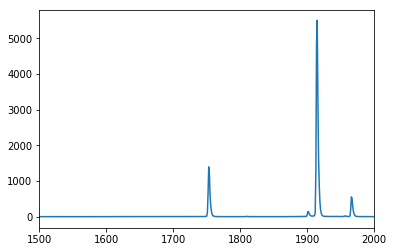

In [9]:
plt.plot(spectrum1D)
plt.xlim(1500,2000)
plt.axvline(x=2253.4,c='r')

In [10]:
# set up calibration points

length = len(list1) 
cali1 = spectrum1D_list.index(list1[length-1])
cali2 = spectrum1D_list.index(list1[length-3])
cali3 = spectrum1D_list.index(list1[length-5])
cali4 = spectrum1D_list.index(list1[length-8])
cali5 = spectrum1D_list.index(list1[length-10])
cali6 = spectrum1D_list.index(list1[length-12])

cali7 = spectrum1D_list.index(list1[length-13])
cali8 = spectrum1D_list.index(list1[length-18])
cali9 = spectrum1D_list.index(list1[length-22])


or1 = 7032.413 #
or2 = 6402.246 #
or3 = 6678.276 #
or4 = 7245.167 #
or5 = 6506.528 #
or6 = 6143.062 #

or7 = 6382.991 #
or8 = 6334.428 # 
or9 = 6929.468 # 

x = np.array([cali1, cali2, cali3, cali4, cali5,
              cali6,cali7, cali8, cali9])
y = np.array([or1, or2, or3, or4, or5,or6,
             or7,or8,or9])
print(x)

[1915  937 1363 2253 1098  535  907  832 1753]


In [11]:
# Linear fit function

def linfit(xdata, ydata, yerror):
    def U(n):
        U_n = sum((xdata**n)/(yerror**2), 0)
        return U_n
    def W(n): 
        W_n = sum(ydata * (xdata**n) / (yerror**2)) 
        return W_n
    D = U(0) * U(2) - (U(1)**2)
    slope = (U(0)*W(1) - U(1)*W(0)) / D
    intercept = (U(2)*W(0) - U(1)*W(1)) / D
    sigma_slope = U(0)/D
    sigma_intercept = U(2)/D
    return slope, intercept

# Fitting slope and intercept

slope = linfit(x,y,1)[0]
inter = linfit(x,y,1)[1]

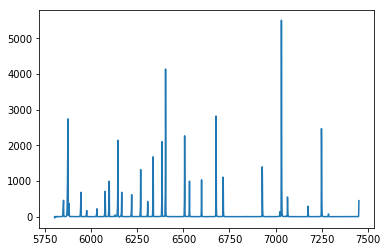

In [14]:
pixel = np.linspace(1,len(spectrum1D),len(spectrum1D))
cali = slope*pixel+inter

# spectrum with lines id

plt.plot(cali,spectrum1D)
plt.show()

y= 0.642814613386485 x+ 5800.269909667825


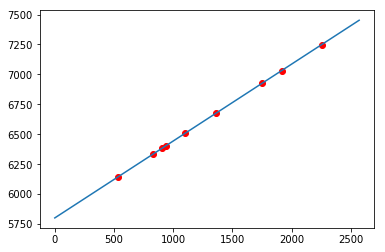

In [15]:
plt.plot(pixel,cali)
plt.scatter(x,y,c='r')
print("y=",slope,"x+",inter)

# IC4202 
### r1169,r1170

In [16]:
# reducing both
def reduce_science(science_folder, cali_folder):
    
    L = science_folder
    Reduced = []
    
    # define bias frame
    bias_frame = get_bias(cali_folder)
    Flat_frame = Flat(cali_folder)
    
    for file in L:
        hdul = fits.open(file)
        image_data = hdul[0].data[80:2650,100:400]
        image_header = hdul[0].header
        
        DATA = (image_data - bias_frame) / Flat_frame
        new_file = file[0:5]+"_RDU"+file[5:10]
        outhdu = fits.PrimaryHDU(data = DATA, header = image_header)
        outhdu.writeto(new_file,overwrite=True)
        
        Reduced.append(new_file)
    return Reduced

In [17]:
IC4202 = ['r1169.fits','r1170.fits']

reduce_science(IC4202,filename)

['r1169_RDU.fits', 'r1170_RDU.fits']

In [125]:

data1 = fits.open('r1169_RDU.fits')[0].data
data2 = fits.open('r1170_RDU.fits')[0].data

new_array = np.zeros(data1.shape)
swaped = np.swapaxes(new_array, 0, 1)

for i in range(data1.shape[0]):
    for j in range(data1.shape[1]):
        new_array[i,j] = min(data1[i,j],data2[i,j])
        
image_header = fits.open('r1169.fits')[0].header
new_file = "IC4202.fits"
outhdu = fits.PrimaryHDU(data = swaped, header = image_header)
outhdu.writeto(new_file,overwrite=True)


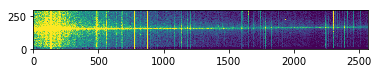

In [19]:
IC_array = fits.open('IC4202.fits')[0].data

a = IC_array
plt.imshow(a, vmin= np.percentile(a, 5), vmax =np.percentile(a, 95), origin='lower')

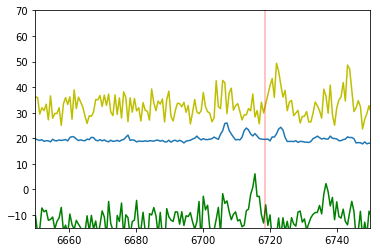

In [27]:
spec2D = IC_array
spec1D = np.mean(spec2D,axis=0)
#spec_a = np.mean(spec2D[130:150],axis=0)
#spec_b = np.mean(spec2D[150:170],axis=0)

spec_a = spec2D[130]
spec_b = spec2D[170]



gauss_kernel = Gaussian1DKernel(3)
spec1D_sm = convolve(spec1D, gauss_kernel)



pixel = np.linspace(1,len(spec1D),len(spec1D))
cali = slope*pixel+inter

plt.plot(cali,spec1D)
plt.plot(cali,spec_a+10,c='y')
plt.plot(cali,spec_b-40,c='g')
plt.xlim(6650,6750)
plt.ylim(-15,70)

z = 0.0237
z_x = 6563*(z+1)
plt.axvline(z_x,c='r',alpha=0.3)

39.299270887949696


1433

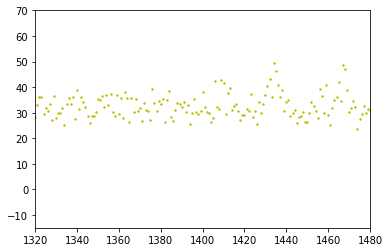

In [31]:
plt.scatter(pixel,spec_a+10,c='y',s=2)
plt.xlim(1320,1480)
plt.ylim(-15,70)
h_alpha = max(spec_a[1330:1530])
print(h_alpha)

list(spec_a).index(h_alpha)

In [105]:

wave_list = []
for i in range(len(spec2D)):
    # 2D-> 1D
    spec_1D = spec2D[i]
    # Smoothening 1D
    gauss_kernel = Gaussian1DKernel(1)
    spec_1D_sm = convolve(spec_1D, gauss_kernel)
    # find value of the brightest pixel
    h_alpha = max(spec_1D_sm[1405:1450])
    # find position of the pixel
    wave_ele = list(spec_1D_sm[1405:1450]).index(h_alpha)
    # create list
    wave_list.append(wave_ele)
    
    
    
trail_wave_list = []
for i in range(len(spec2D)):
    
    # 2D-> 1D
    spec_1D = spec2D[i]
    
    # Smoothening 1D
    gauss_kernel = Gaussian1DKernel(1)
    spec_1D_sm = convolve(spec_1D, gauss_kernel)
    
    # Truncation 1D to 1415~1440
    spec_1D_trunc = spec_1D_sm[1405:1450]
    
    # Build new list to include the "Sum of each 5 element" as gaussian sum
    sum_spec_1D = []
    for i in range(len(spec_1D_trunc)):
        sum_1D_value = sum(spec_1D_trunc[i-3:i+3])
        sum_spec_1D.append(sum_1D_value)
    
    h_alpha = max(sum_spec_1D)
    x_pixel_index = list(sum_spec_1D).index(h_alpha)
    trail_wave_list.append(x_pixel_index)
    


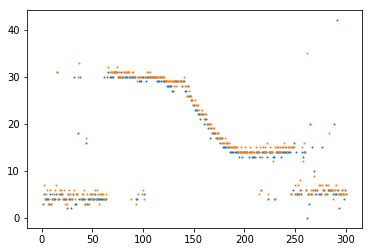

In [106]:
#0.43*arcsec
#110.66*Mpc

pix2ly = np.deg2rad(0.43/3600)*110.66e3

wave = []
velocity = []

for i in wave_list:
    obs = (int(i)+1406)*slope+inter
    z = (obs-6562.)/6562.8
    v = z*299792.458
    
    wave.append(obs)
    velocity.append(v)
    
pixel = np.linspace(1,300,300)
plt.scatter(pixel,wave_list,s=1)
plt.scatter(pixel,trail_wave_list,s=1)
#plt.xlim(85,120)
#plt.ylim(80,150)


In [24]:
pixel_ind = 5.775953067e-15 * 9.4607e12 #km
pixel_ind

0.0546445591809669

## IC4204 Velocity Dispersion Model

/Users/runquanguan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


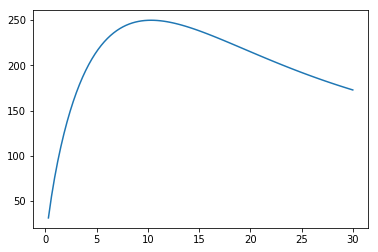

In [47]:
model_v = []

def V_SQ_R(R):
    G = 4.302e-6 #m3 kg-1 s-2
    
    m_stellar = 180e9
    Rd = 4.8
    sigma_0 = m_stellar/(2*np.pi*Rd**2)
    y = R/(2*Rd)
    
    I0 = sp.iv(0,y)
    I1 = sp.iv(1,y)
    
    K0 = sp.kv(0,y)
    K1 = sp.kv(1,y)

    V2 = 4*np.pi*G*sigma_0*Rd*(y**2)*(I0*K0-I1*K1)
    v = np.sqrt(V2)
    return v

for i in np.linspace(0,30,100):
    modelv = V_SQ_R(i)
    model_v.append(modelv)
    
    
# now model_v is the set of model velocity

plt.plot(np.linspace(0,30,100),model_v)

# UGC7321 
### r1171, 73, 74, 75

In [107]:
UGC7321 = ['r1171.fits','r1173.fits','r1174.fits','r1175.fits']

reduce_science(UGC7321,filename)

['r1171_RDU.fits', 'r1173_RDU.fits', 'r1174_RDU.fits', 'r1175_RDU.fits']

In [132]:
# Clean Cosmic Rays

data1 = fits.open('r1171_RDU.fits')[0].data
data2 = fits.open('r1173_RDU.fits')[0].data
data3 = fits.open('r1174_RDU.fits')[0].data
data4 = fits.open('r1175_RDU.fits')[0].data

# Create a array of all zero
new_array = np.zeros(data1.shape)
swaped = np.swapaxes(new_array, 0, 1)


for i in range(data1.shape[0]):
    for j in range(data1.shape[1]):
        a = data1[i,j]
        b = data2[i,j]
        c = data3[i,j]
        d = data4[i,j]
        new_array[i,j] = (sum([a,b,c,d])-max(a,b,c,d))/3
        
image_header = fits.open('r1171.fits')[0].header
new_file = "UGC7321.fits"
outhdu = fits.PrimaryHDU(data = swaped, header = image_header)
outhdu.writeto(new_file,overwrite=True)



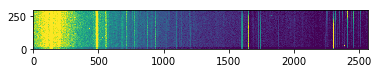

In [133]:
UGC_array = fits.open('UGC7321.fits')[0].data

a = UGC_array
plt.imshow(a, vmin= np.percentile(a, 5), vmax =np.percentile(a, 95), origin='lower')

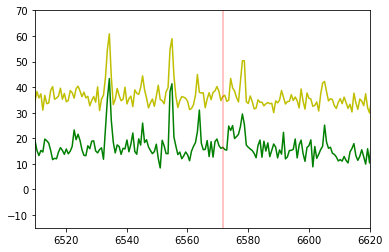

In [152]:
UGC_spec2D = UGC_array
UGC_spec1D = np.mean(spec2D,axis=0)
#spec_a = np.mean(spec2D[130:150],axis=0)
#spec_b = np.mean(spec2D[150:170],axis=0)

UGC_spec_a = UGC_spec2D[30]
UGC_spec_b = UGC_spec2D[150]



gauss_kernel = Gaussian1DKernel(3)
UGC_spec1D_sm = convolve(UGC_spec1D, gauss_kernel)



pixel = np.linspace(1,len(UGC_spec1D),len(UGC_spec1D))
cali = slope*pixel+inter

plt.plot(cali,UGC_spec_a+10,c='y')
plt.plot(cali,UGC_spec_b-10,c='g')
plt.xlim(6510,6620)
plt.ylim(-15,70)

z = 0.00136
z_x = 6562.8*(z+1)
plt.axvline(z_x,c='r',alpha=0.3)

In [161]:
# image after reduce

xrows = np.arange(UGC_spec2D.shape[0])
bkg = np.zeros_like(UGC_spec2D)
x = np.arange(20,60)+np.arange(220,260)
for col in np.arange(UGC_spec2D.shape[1]):
    pfit = np.polyfit(x, UGC_spec2D[x, col], 2)
    bkg[:, col] = np.polyval(pfit,xrows)
    
plt.clf()
plt.imshow(bkg, origin='lower', vmin=np.percentile(bkg,5), vmax=np.percentile(bkg,95))
plt.colorbar()

reduced = UGC_spec2D - bkg
a = reduced

plt.imshow(reduced, vmin= np.percentile(a, 5), vmax =np.percentile(a, 95), origin='lower')

IndexError: index 300 is out of bounds for axis 0 with size 300

SyntaxError: invalid syntax (<ipython-input-166-ba3ebec6ec5f>, line 1)

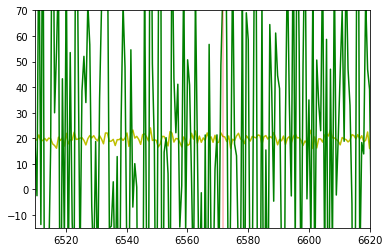

In [160]:
UGC_spec2D = reduced
UGC_spec1D = np.mean(spec2D,axis=0)
#spec_a = np.mean(spec2D[130:150],axis=0)
#spec_b = np.mean(spec2D[150:170],axis=0)

UGC_spec_a = UGC_spec2D[150]
UGC_spec_b = UGC_spec2D[130]



gauss_kernel = Gaussian1DKernel(3)
UGC_spec1D_sm = convolve(UGC_spec1D, gauss_kernel)



pixel = np.linspace(1,len(UGC_spec1D),len(UGC_spec1D))
cali = slope*pixel+inter

plt.plot(cali,UGC_spec_a+20,c='y')
plt.plot(cali,UGC_spec_b+10,c='g')
plt.xlim(6510,6620)
plt.ylim(-15,70)

z = 0.00136
z_x = 6562.8*(z+1)
plt.axvline(z_x,c='r',alpha=0.3)